### Video Classification using Transformer

In [35]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp 

import torch 
import torch.nn as nn
import torch.nn.functional as F

In [36]:
mp_holist = mp.solutions.holistic 
mp_draw = mp.solutions.drawing_utils

In [37]:
def mediapipe_detection(img, model):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img.flags.writeable = False                 
    result = model.process(img)                 # Make prediction
    img.flags.writeable = True                   
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
    return img, result

In [38]:
def draw_landmarks(img, result):
    mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS) # Draw face connections
    mp_draw.draw_landmarks(img, result.pose_landmarks, mp_holist.POSE_CONNECTIONS) # Draw pose connections
    mp_draw.draw_landmarks(img, result.left_hand_landmarks, mp_holist.HAND_CONNECTIONS) # Draw left hand connections
    mp_draw.draw_landmarks(img, result.right_hand_landmarks, mp_holist.HAND_CONNECTIONS) # Draw right hand connections

In [39]:
def draw_styled_landmarks(img, result):
    mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS, 
                             mp_draw.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # color the joint 
                             mp_draw.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) #color the connection
                             ) 
    # mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS, 
    #                          mp_draw.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # color the joint 
    #                          mp_draw.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) #color the connection
    #                          ) 
    
    mp_draw.draw_landmarks(img, result.pose_landmarks, mp_holist.POSE_CONNECTIONS,
                             mp_draw.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    mp_draw.draw_landmarks(img, result.left_hand_landmarks, mp_holist.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    mp_draw.draw_landmarks(img, result.right_hand_landmarks, mp_holist.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [40]:
def extract_keypoints(results):
    pose=np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    left_hnd=np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    right_hnd=np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    face=np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    return np.concatenate([pose,left_hnd,right_hnd,face])
# concatenating for the model to detect the sign language

In [41]:
import os 
video_dir = "C:/Users/araya/Desktop/keypoints/video_extract"
video_list = []
video_list = os.listdir(video_dir)

len(video_list)

40

In [42]:
video_list

['กฎกระทรวง.mp4',
 'กฎหมายรัฐธรรมนูญ.mp4',
 'กรมอนามัย.mp4',
 'กรรม.mp4',
 'กรรมสิทธิ์.mp4',
 'กระโดด.mp4',
 'กล้วยบวชชี.mp4',
 'กล้วยเชื่อม.mp4',
 'กังวล.mp4',
 'กีฬา.mp4',
 'น้อง.mp4',
 'เขิน.mp4',
 'เขื่อนดิน.mp4',
 'เขื่อนสิริกิติ์.mp4',
 'เข้าใจผิด.mp4',
 'เคย.mp4',
 'เครียด.mp4',
 'เครื่องปั่นดิน.mp4',
 'เครื่องหมายการค้า.mp4',
 'เจอ.mp4',
 'เจ้าหนี้.mp4',
 'เช่าซื้อ.mp4',
 'เช่าทรัพย์.mp4',
 'เซอร์เบีย.mp4',
 'เซเนกัล.mp4',
 'เซ็ง.mp4',
 'เดิน.mp4',
 'เดิมพัน.mp4',
 'เพลีย.mp4',
 'เมื่อย.mp4',
 'เม็กซิโก.mp4',
 'เฮโรอีน.mp4',
 'แกมเบีย.mp4',
 'แซมเบีย.mp4',
 'โกหก.mp4',
 'โจทก์.mp4',
 'โชจู.mp4',
 'ใกล้.mp4',
 'ไดโนเสาร์.mp4',
 'ไอซ์.mp4']

In [43]:
# Path for exported data, numpy arrays
Model_Data=os.path.join('Data for different actions')

actions = np.array(video_list)

no_of_seqs = 1

# 30 frames in length
seq_length = 160

In [44]:
actions

array(['กฎกระทรวง.mp4', 'กฎหมายรัฐธรรมนูญ.mp4', 'กรมอนามัย.mp4',
       'กรรม.mp4', 'กรรมสิทธิ์.mp4', 'กระโดด.mp4', 'กล้วยบวชชี.mp4',
       'กล้วยเชื่อม.mp4', 'กังวล.mp4', 'กีฬา.mp4', 'น้อง.mp4', 'เขิน.mp4',
       'เขื่อนดิน.mp4', 'เขื่อนสิริกิติ์.mp4', 'เข้าใจผิด.mp4', 'เคย.mp4',
       'เครียด.mp4', 'เครื่องปั่นดิน.mp4', 'เครื่องหมายการค้า.mp4',
       'เจอ.mp4', 'เจ้าหนี้.mp4', 'เช่าซื้อ.mp4', 'เช่าทรัพย์.mp4',
       'เซอร์เบีย.mp4', 'เซเนกัล.mp4', 'เซ็ง.mp4', 'เดิน.mp4',
       'เดิมพัน.mp4', 'เพลีย.mp4', 'เมื่อย.mp4', 'เม็กซิโก.mp4',
       'เฮโรอีน.mp4', 'แกมเบีย.mp4', 'แซมเบีย.mp4', 'โกหก.mp4',
       'โจทก์.mp4', 'โชจู.mp4', 'ใกล้.mp4', 'ไดโนเสาร์.mp4', 'ไอซ์.mp4'],
      dtype='<U21')

Collecting keypoint values for Training nd Testing

In [45]:
# Define the directory where your videos are stored
directory = "C:/Users/araya/Desktop/keypoints/video_extract"

In [46]:
directory

'C:/Users/araya/Desktop/keypoints/video_extract'

In [47]:
for filename in actions:
    print(directory + '/' + filename)

C:/Users/araya/Desktop/keypoints/video_extract/กฎกระทรวง.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กฎหมายรัฐธรรมนูญ.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กรมอนามัย.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กรรม.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กรรมสิทธิ์.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กระโดด.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กล้วยบวชชี.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กล้วยเชื่อม.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กังวล.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กีฬา.mp4
C:/Users/araya/Desktop/keypoints/video_extract/น้อง.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เขิน.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เขื่อนดิน.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เขื่อนสิริกิติ์.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เข้าใจผิด.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เคย.mp4
C:/Users/araya/Desktop/keypoints/video_e

In [48]:
file_paths = []
for action in actions:
    video_path = os.path.join('Data for different actions/', action)
    # print(video_path)
    # print(action)
    file_paths.append(video_path + '/' + action.split(".")[0] + ".npy")
print(file_paths)

['Data for different actions/กฎกระทรวง.mp4/กฎกระทรวง.npy', 'Data for different actions/กฎหมายรัฐธรรมนูญ.mp4/กฎหมายรัฐธรรมนูญ.npy', 'Data for different actions/กรมอนามัย.mp4/กรมอนามัย.npy', 'Data for different actions/กรรม.mp4/กรรม.npy', 'Data for different actions/กรรมสิทธิ์.mp4/กรรมสิทธิ์.npy', 'Data for different actions/กระโดด.mp4/กระโดด.npy', 'Data for different actions/กล้วยบวชชี.mp4/กล้วยบวชชี.npy', 'Data for different actions/กล้วยเชื่อม.mp4/กล้วยเชื่อม.npy', 'Data for different actions/กังวล.mp4/กังวล.npy', 'Data for different actions/กีฬา.mp4/กีฬา.npy', 'Data for different actions/น้อง.mp4/น้อง.npy', 'Data for different actions/เขิน.mp4/เขิน.npy', 'Data for different actions/เขื่อนดิน.mp4/เขื่อนดิน.npy', 'Data for different actions/เขื่อนสิริกิติ์.mp4/เขื่อนสิริกิติ์.npy', 'Data for different actions/เข้าใจผิด.mp4/เข้าใจผิด.npy', 'Data for different actions/เคย.mp4/เคย.npy', 'Data for different actions/เครียด.mp4/เครียด.npy', 'Data for different actions/เครื่องปั่นดิน.mp4/เครื

In [49]:
def load_keypoint_sequences(file_paths):
    keypoint_sequences = []
    for file_path in file_paths:
        print(file_path)
        keypoints = np.load(file_path)
        keypoint_sequences.append(torch.tensor(keypoints, dtype=torch.float32))
    return keypoint_sequences

In [50]:
# Load the sequences
import torch
sequences = load_keypoint_sequences(file_paths)
sequences

Data for different actions/กฎกระทรวง.mp4/กฎกระทรวง.npy
Data for different actions/กฎหมายรัฐธรรมนูญ.mp4/กฎหมายรัฐธรรมนูญ.npy
Data for different actions/กรมอนามัย.mp4/กรมอนามัย.npy
Data for different actions/กรรม.mp4/กรรม.npy
Data for different actions/กรรมสิทธิ์.mp4/กรรมสิทธิ์.npy
Data for different actions/กระโดด.mp4/กระโดด.npy
Data for different actions/กล้วยบวชชี.mp4/กล้วยบวชชี.npy
Data for different actions/กล้วยเชื่อม.mp4/กล้วยเชื่อม.npy
Data for different actions/กังวล.mp4/กังวล.npy
Data for different actions/กีฬา.mp4/กีฬา.npy
Data for different actions/น้อง.mp4/น้อง.npy
Data for different actions/เขิน.mp4/เขิน.npy
Data for different actions/เขื่อนดิน.mp4/เขื่อนดิน.npy
Data for different actions/เขื่อนสิริกิติ์.mp4/เขื่อนสิริกิติ์.npy
Data for different actions/เข้าใจผิด.mp4/เข้าใจผิด.npy
Data for different actions/เคย.mp4/เคย.npy
Data for different actions/เครียด.mp4/เครียด.npy
Data for different actions/เครื่องปั่นดิน.mp4/เครื่องปั่นดิน.npy
Data for different actions/เครื่องหมาย

[tensor([[ 0.5013,  0.2452, -1.2167,  ...,  0.5663,  0.2188,  0.0098],
         [ 0.4997,  0.2482, -1.4690,  ...,  0.5652,  0.2181,  0.0106],
         [ 0.4984,  0.2500, -1.4853,  ...,  0.5654,  0.2185,  0.0112],
         ...,
         [ 0.4861,  0.2513, -1.3416,  ...,  0.5572,  0.2177,  0.0091],
         [ 0.4873,  0.2514, -1.3574,  ...,  0.5575,  0.2172,  0.0097],
         [ 0.4883,  0.2516, -1.3579,  ...,  0.5577,  0.2170,  0.0101]]),
 tensor([[ 0.4922,  0.2382, -1.2850,  ...,  0.5578,  0.2124,  0.0094],
         [ 0.4920,  0.2405, -1.4288,  ...,  0.5571,  0.2116,  0.0099],
         [ 0.4920,  0.2409, -1.4093,  ...,  0.5567,  0.2122,  0.0098],
         ...,
         [ 0.4814,  0.2260, -1.3318,  ...,  0.5503,  0.1923,  0.0123],
         [ 0.4815,  0.2257, -1.3351,  ...,  0.5503,  0.1921,  0.0122],
         [ 0.4815,  0.2255, -1.3497,  ...,  0.5501,  0.1919,  0.0124]]),
 tensor([[ 0.5049,  0.2371, -1.2115,  ...,  0.5643,  0.2082,  0.0088],
         [ 0.5045,  0.2381, -1.1896,  ...,  0

In [51]:
print(type(sequences))
print(sequences[0].shape)
print(sequences[1].shape)
print(sequences[2].shape)
print(sequences[3].shape)
print(sequences[4].shape)
print("We can see that each row (lenght of video) is not the same size, so we need to pad them.")

<class 'list'>
torch.Size([142, 1662])
torch.Size([134, 1662])
torch.Size([151, 1662])
torch.Size([100, 1662])
torch.Size([160, 1662])
We can see that each row (lenght of video) is not the same size, so we need to pad them.


In [52]:
# Pad the sequences to the same length
from torch.nn.utils.rnn import pad_sequence
padded_sequences = pad_sequence(sequences, batch_first=True)
print(padded_sequences.shape) # (batch_size, max_sequence_length, num_keypoints)

torch.Size([40, 160, 1662])


In [53]:
print(type(padded_sequences))
print(padded_sequences[0].shape)
print(padded_sequences[1].shape)
print(padded_sequences[2].shape)
print(padded_sequences[3].shape)
print(padded_sequences[4].shape)

<class 'torch.Tensor'>
torch.Size([160, 1662])
torch.Size([160, 1662])
torch.Size([160, 1662])
torch.Size([160, 1662])
torch.Size([160, 1662])


In [54]:
sequences[2] 

tensor([[ 0.5049,  0.2371, -1.2115,  ...,  0.5643,  0.2082,  0.0088],
        [ 0.5045,  0.2381, -1.1896,  ...,  0.5643,  0.2081,  0.0085],
        [ 0.5041,  0.2385, -1.1915,  ...,  0.5643,  0.2080,  0.0089],
        ...,
        [ 0.4963,  0.2307, -1.3096,  ...,  0.5624,  0.2043,  0.0127],
        [ 0.4965,  0.2308, -1.3085,  ...,  0.5625,  0.2045,  0.0126],
        [ 0.4972,  0.2312, -1.3053,  ...,  0.5633,  0.2045,  0.0128]])

In [55]:
labels = [action.split(".")[0] for action in actions]
labels

['กฎกระทรวง',
 'กฎหมายรัฐธรรมนูญ',
 'กรมอนามัย',
 'กรรม',
 'กรรมสิทธิ์',
 'กระโดด',
 'กล้วยบวชชี',
 'กล้วยเชื่อม',
 'กังวล',
 'กีฬา',
 'น้อง',
 'เขิน',
 'เขื่อนดิน',
 'เขื่อนสิริกิติ์',
 'เข้าใจผิด',
 'เคย',
 'เครียด',
 'เครื่องปั่นดิน',
 'เครื่องหมายการค้า',
 'เจอ',
 'เจ้าหนี้',
 'เช่าซื้อ',
 'เช่าทรัพย์',
 'เซอร์เบีย',
 'เซเนกัล',
 'เซ็ง',
 'เดิน',
 'เดิมพัน',
 'เพลีย',
 'เมื่อย',
 'เม็กซิโก',
 'เฮโรอีน',
 'แกมเบีย',
 'แซมเบีย',
 'โกหก',
 'โจทก์',
 'โชจู',
 'ใกล้',
 'ไดโนเสาร์',
 'ไอซ์']

In [56]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

labels = le.fit_transform(labels)
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39], dtype=int64)

In [57]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Create a custom dataset
class KeypointDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        keypoints = np.load(self.file_paths[idx])
        label = self.labels[idx]
        return torch.tensor(keypoints, dtype=torch.float32), label

In [58]:
# Create the dataset
dataset = KeypointDataset(file_paths, labels)

In [59]:
dataset

In [60]:
print(dataset.file_paths)
print(dataset.labels)

['Data for different actions/กฎกระทรวง.mp4/กฎกระทรวง.npy', 'Data for different actions/กฎหมายรัฐธรรมนูญ.mp4/กฎหมายรัฐธรรมนูญ.npy', 'Data for different actions/กรมอนามัย.mp4/กรมอนามัย.npy', 'Data for different actions/กรรม.mp4/กรรม.npy', 'Data for different actions/กรรมสิทธิ์.mp4/กรรมสิทธิ์.npy', 'Data for different actions/กระโดด.mp4/กระโดด.npy', 'Data for different actions/กล้วยบวชชี.mp4/กล้วยบวชชี.npy', 'Data for different actions/กล้วยเชื่อม.mp4/กล้วยเชื่อม.npy', 'Data for different actions/กังวล.mp4/กังวล.npy', 'Data for different actions/กีฬา.mp4/กีฬา.npy', 'Data for different actions/น้อง.mp4/น้อง.npy', 'Data for different actions/เขิน.mp4/เขิน.npy', 'Data for different actions/เขื่อนดิน.mp4/เขื่อนดิน.npy', 'Data for different actions/เขื่อนสิริกิติ์.mp4/เขื่อนสิริกิติ์.npy', 'Data for different actions/เข้าใจผิด.mp4/เข้าใจผิด.npy', 'Data for different actions/เคย.mp4/เคย.npy', 'Data for different actions/เครียด.mp4/เครียด.npy', 'Data for different actions/เครื่องปั่นดิน.mp4/เครื

In [61]:
# Collate function for padding
def collate_fn(batch):
    sequences, labels = zip(*batch)
    padded_sequences = pad_sequence(sequences, batch_first=True)
    return padded_sequences, torch.tensor(labels)

In [62]:
# Create the DataLoader
batch_size = 4
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
data_loader

In [63]:
# Set device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Transformer

In [64]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.metrics import f1_score

# class AttentionLayer(nn.Module):
#     def __init__(self, hidden_size):
#         super(AttentionLayer, self).__init__()
#         self.attention_weights = nn.Linear(hidden_size, 1, bias=False)

#     def forward(self, lstm_output):
#         # lstm_output: (batch_size, sequence_length, hidden_size)
#         attention_scores = self.attention_weights(lstm_output)  # (batch_size, sequence_length, 1)
#         attention_weights = torch.softmax(attention_scores, dim=1)  # (batch_size, sequence_length, 1)
#         weighted_output = torch.sum(lstm_output * attention_weights, dim=1)  # (batch_size, hidden_size)
#         return weighted_output, attention_weights

In [65]:
# class Encoder(nn.Module):
#     def __init__(self, input_size, num_heads, dropout):
#         super().__init__()
#         self.multihead = nn.MultiheadAttention(embed_dim=input_size, num_heads=num_heads)
#         self.normalize_layer = nn.LayerNorm(normalized_shape=input_size, eps=1e-5)
#         self.fc1 = nn.Linear(input_size, input_size)
#         self.pool = nn.MaxPool2d(kernel_size=(2,1), stride=1)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x):
#         attn_output, attn_output_weights = self.multihead(x, x, x)

#         normalize_attn = self.normalize_layer(x+attn_output)

#         final_output = self.normalize_layer(self.fc1(normalize_attn)+normalize_attn)

#         final_output = self.pool(final_output)

#         return final_output

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

class Encoder(nn.Module):
    def __init__(self, input_size, num_heads, dropout, num_classes):
        super().__init__()
        self.multihead = nn.MultiheadAttention(embed_dim=input_size, num_heads=num_heads)
        self.normalize_layer = nn.LayerNorm(normalized_shape=input_size, eps=1e-5)
        self.fc1 = nn.Linear(input_size, input_size)
        self.fc2 = nn.Linear(input_size, num_classes)  # Output layer for classification
        self.pool = nn.MaxPool1d(kernel_size=2, stride=1)  # Changed to MaxPool1d
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x should have shape [sequence_length, batch_size, input_size] for MultiheadAttention
        attn_output, _ = self.multihead(x, x, x)  # Self-attention

        normalize_attn = self.normalize_layer(x + attn_output)  # Add & Norm
        final_output = self.normalize_layer(self.fc1(normalize_attn) + normalize_attn)  # Another Add & Norm

        # Assuming you're pooling over the sequence length (dimension 0)
        pooled_output = self.pool(final_output.permute(1, 2, 0))  # Pooling across sequence length

        pooled_output = pooled_output.permute(2, 0, 1)  # Permute back to [sequence_length, batch_size, input_size]
        pooled_output = pooled_output[-1]  # Take the last time step for classification

        output = self.fc2(pooled_output)  # Final classification layer

        return output

In [67]:
# Initialize the model, loss function, and optimizer
model = Encoder(input_size=1662, num_heads=6, dropout=0.5, num_classes=40).to(device)

In [68]:
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [69]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 13889374 (Approximately 13 Million) Parameters!


In [70]:
data_loader.dataset.labels[2]

2

In [73]:
# Training loop
# References : https://saturncloud.io/blog/calculating-the-accuracy-of-pytorch-models-every-epoch/#:~:text=In%20order%20to%20calculate%20the,tensor%20along%20a%20specified%20dimension

from sklearn.metrics import f1_score, recall_score

num_epochs = 400
loss_logger = []
accuracy_logger = []
# n_epochs = []

f1_logger = []
recall_logger = []

all_preds = []
all_labels = []

for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    model.train()
    for i, (sequences, labels) in enumerate(data_loader):
        # Move data to the device
        # labels = labels.type(torch.LongTensor)   # casting to long
        sequences = sequences.to(device)
        sequences = sequences.permute(1, 0, 2)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(sequences)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Store predictions and labels for calculating metrics
        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())    # Store true labels
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss_logger.append(loss.item())
    loss_logger.append(loss.item())
    accuracy = 100 * total_correct /total_samples

    # Calculate F1 score and recall
    f1 = f1_score(all_labels, all_preds, average='weighted')  # Weighted average for multi-class
    recall = recall_score(all_labels, all_preds, average='weighted')

    f1_logger.append(f1)
    recall_logger.append(recall)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f} , Accuracy : {accuracy/10:.2f}%, F1 Score: {f1:.2f}, Recall: {recall:.2f}')
    accuracy_logger.append(accuracy)
    # n_epochs.append(epoch)

Epoch [1/400], Loss: 7.9652 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [2/400], Loss: 6.8454 , Accuracy : 2.50%, F1 Score: 0.00, Recall: 0.01
Epoch [3/400], Loss: 5.0689 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.01
Epoch [4/400], Loss: 4.7200 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.01
Epoch [5/400], Loss: 4.8468 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.01
Epoch [6/400], Loss: 5.1829 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [7/400], Loss: 5.4175 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [8/400], Loss: 5.1743 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [9/400], Loss: 4.8840 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [10/400], Loss: 4.7261 , Accuracy : 2.50%, F1 Score: 0.00, Recall: 0.01
Epoch [11/400], Loss: 4.8125 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [12/400], Loss: 4.5254 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [13/400], Loss: 5.0001 , Accuracy : 5.00%, F1 Score: 0.01, Recall: 

In [74]:
loss_logger

[7.965182304382324,
 6.845428466796875,
 5.06888484954834,
 4.719999313354492,
 4.846808433532715,
 5.182885646820068,
 5.417502403259277,
 5.174251556396484,
 4.883986473083496,
 4.726085662841797,
 4.812484264373779,
 4.525403022766113,
 5.000095367431641,
 4.945257663726807,
 4.329648017883301,
 4.147042274475098,
 4.710289478302002,
 4.996196746826172,
 4.052335262298584,
 4.365033149719238,
 4.789646625518799,
 4.706047058105469,
 4.430502891540527,
 3.94478702545166,
 3.373466968536377,
 4.482137680053711,
 4.57429838180542,
 3.6383934020996094,
 3.855522632598877,
 3.4879233837127686,
 4.423927307128906,
 3.8667821884155273,
 3.2934317588806152,
 3.517024517059326,
 4.200308322906494,
 3.794834613800049,
 3.0977978706359863,
 3.2822747230529785,
 3.0343964099884033,
 3.423948287963867,
 3.883380651473999,
 2.5536179542541504,
 2.6105620861053467,
 2.9809393882751465,
 4.608216285705566,
 2.8625383377075195,
 3.4741616249084473,
 3.223916530609131,
 2.259416341781616,
 3.91928911

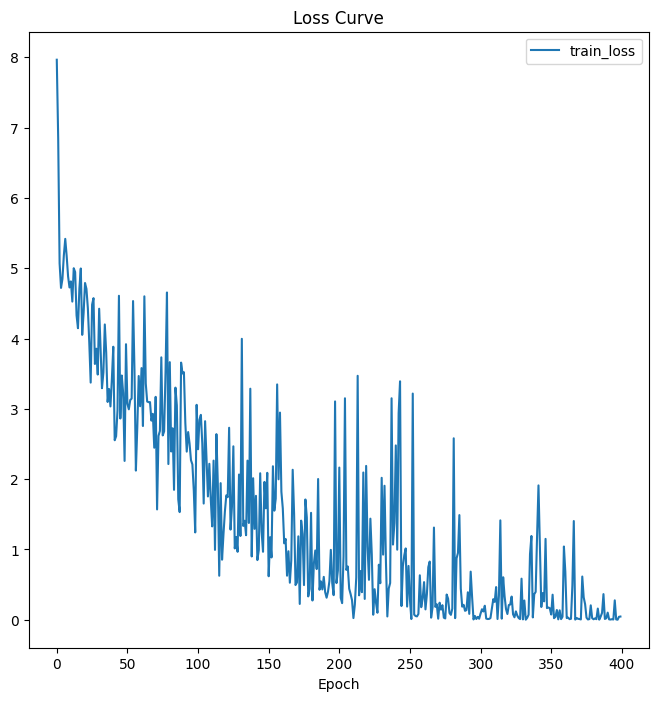

In [77]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
plt.title("Loss Curve")
plt.plot(loss_logger, label='train_loss')
# plt.plot(accuracy_logger,label='accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Save and Load Model

In [78]:
pad_sequence(sequences, batch_first=True)

tensor([[[ 0.5410,  0.2495, -1.3908,  ...,  0.6085,  0.2224,  0.0099],
         [ 0.4813,  0.2267, -1.2462,  ...,  0.5499,  0.2013,  0.0123],
         [ 0.5269,  0.2488, -1.5232,  ...,  0.5929,  0.2181,  0.0118],
         [ 0.4992,  0.1994, -1.1906,  ...,  0.5657,  0.1731,  0.0116]],

        [[ 0.5399,  0.2502, -1.3960,  ...,  0.6066,  0.2219,  0.0111],
         [ 0.4796,  0.2283, -1.4595,  ...,  0.5479,  0.2026,  0.0127],
         [ 0.5260,  0.2493, -1.4445,  ...,  0.5918,  0.2172,  0.0111],
         [ 0.4988,  0.2047, -1.3590,  ...,  0.5663,  0.1723,  0.0123]],

        [[ 0.5390,  0.2511, -1.3861,  ...,  0.6062,  0.2215,  0.0105],
         [ 0.4786,  0.2300, -1.5108,  ...,  0.5480,  0.2025,  0.0122],
         [ 0.5250,  0.2497, -1.4588,  ...,  0.5916,  0.2171,  0.0113],
         [ 0.4982,  0.2082, -1.3140,  ...,  0.5671,  0.1730,  0.0129]],

        ...,

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.4782,  0.2297, -1.2598,  ...,  0.5464,  0.19

In [79]:
# Put the model in evaluation mode
model.eval()

# No need to track gradients during inference
with torch.no_grad():
    # Get the model's output (logits)
    outputs = model(padded_sequences.to(device))

# outputs = torch.softmax(outputs, dim=1)
# outputs = torch.max(outputs,1)

outputs


tensor([[ -1.8031, -14.2637,   4.2157,  ...,   4.2212,   5.8031,  19.4957],
        [ -0.7538, -13.8045,   3.6985,  ...,   2.6526,   7.6318,  20.8368],
        [ -0.4655, -13.6284,   3.7461,  ...,   2.2438,   7.8954,  20.9952],
        ...,
        [-18.3753,  -5.5197,  -1.1482,  ...,  30.8420, -25.1463, -23.5645],
        [-18.2838,  -5.4439,  -1.6189,  ...,  30.2220, -24.2842, -23.1480],
        [-18.0381,  -5.0602,  -1.7981,  ...,  29.6631, -23.8670, -23.1658]],
       device='cuda:0')

In [80]:
padded_sequences

tensor([[[ 0.5013,  0.2452, -1.2167,  ...,  0.5663,  0.2188,  0.0098],
         [ 0.4997,  0.2482, -1.4690,  ...,  0.5652,  0.2181,  0.0106],
         [ 0.4984,  0.2500, -1.4853,  ...,  0.5654,  0.2185,  0.0112],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.4922,  0.2382, -1.2850,  ...,  0.5578,  0.2124,  0.0094],
         [ 0.4920,  0.2405, -1.4288,  ...,  0.5571,  0.2116,  0.0099],
         [ 0.4920,  0.2409, -1.4093,  ...,  0.5567,  0.2122,  0.0098],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.5049,  0.2371, -1.2115,  ...,  0.5643,  0.2082,  0.0088],
         [ 0.5045,  0.2381, -1.1896,  ...,  0

In [81]:
file_paths = ["Data for different actions/เขิน_0.mp4/เขิน_0.npy"]

In [82]:
# Load the sequences
import torch
sequences = load_keypoint_sequences(file_paths)
# Change list to numpy array 
sequences = np.array(sequences)
# Change numpy array to tensor
sequences = torch.FloatTensor(sequences)
sequences = pad_sequence(sequences, batch_first=True)
sequences

Data for different actions/เขิน_0.mp4/เขิน_0.npy


tensor([[[ 0.4321,  0.2240, -1.4261,  ...,  0.4724,  0.1833,  0.0108],
         [ 0.4325,  0.2250, -1.4727,  ...,  0.4722,  0.1847,  0.0102],
         [ 0.4330,  0.2258, -1.4930,  ...,  0.4725,  0.1845,  0.0109],
         ...,
         [ 0.4396,  0.2238, -1.5889,  ...,  0.4802,  0.1780,  0.0139],
         [ 0.4395,  0.2238, -1.5796,  ...,  0.4802,  0.1776,  0.0141],
         [ 0.4394,  0.2234, -1.5304,  ...,  0.4799,  0.1771,  0.0144]]])

In [83]:
# Add permute for Transformer
sequences = sequences.permute(1, 0, 2)

In [84]:
outputs = model(sequences.to(device))
outputs

tensor([[ 10.7279,  22.4183,   0.5101,  23.1612,  27.1505, -36.1799,  22.8680,
          11.7803,  23.0379, -29.4451,  -6.9964, -16.6007,  -7.6769,  13.0215,
           5.5329,   3.0330,  13.9579,  32.3614,  12.6214,  -2.1421, -22.7129,
          -0.6424,  -8.8586,   3.2055, -18.0327,   0.9104, -17.1245, -14.2854,
         -26.9379, -18.8334,   6.7134,   6.7782,  -9.3975,   2.4317,  10.6752,
          -2.9952,   7.1357,  14.4362, -20.9762, -10.3833]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [85]:
labels = [action.split(".")[0] for action in actions]
labels

['กฎกระทรวง',
 'กฎหมายรัฐธรรมนูญ',
 'กรมอนามัย',
 'กรรม',
 'กรรมสิทธิ์',
 'กระโดด',
 'กล้วยบวชชี',
 'กล้วยเชื่อม',
 'กังวล',
 'กีฬา',
 'น้อง',
 'เขิน',
 'เขื่อนดิน',
 'เขื่อนสิริกิติ์',
 'เข้าใจผิด',
 'เคย',
 'เครียด',
 'เครื่องปั่นดิน',
 'เครื่องหมายการค้า',
 'เจอ',
 'เจ้าหนี้',
 'เช่าซื้อ',
 'เช่าทรัพย์',
 'เซอร์เบีย',
 'เซเนกัล',
 'เซ็ง',
 'เดิน',
 'เดิมพัน',
 'เพลีย',
 'เมื่อย',
 'เม็กซิโก',
 'เฮโรอีน',
 'แกมเบีย',
 'แซมเบีย',
 'โกหก',
 'โจทก์',
 'โชจู',
 'ใกล้',
 'ไดโนเสาร์',
 'ไอซ์']

In [86]:
# Change from tensor to numpy arrat
outputs = outputs.cpu().detach().numpy()

In [87]:
outputs

array([[ 10.727852  ,  22.418259  ,   0.5101288 ,  23.161173  ,
         27.15053   , -36.17989   ,  22.868     ,  11.780274  ,
         23.037855  , -29.445112  ,  -6.9963913 , -16.600716  ,
         -7.67694   ,  13.021479  ,   5.5329084 ,   3.033001  ,
         13.957923  ,  32.36137   ,  12.621409  ,  -2.142116  ,
        -22.712908  ,  -0.64238244,  -8.858594  ,   3.20555   ,
        -18.032671  ,   0.91041595, -17.124454  , -14.2853775 ,
        -26.937916  , -18.833359  ,   6.713405  ,   6.778204  ,
         -9.397466  ,   2.4317484 ,  10.6751585 ,  -2.9952478 ,
          7.1356816 ,  14.436232  , -20.976183  , -10.383338  ]],
      dtype=float32)

In [88]:
for idx, word in enumerate(outputs):
    # max_value = torch.max(outputs)
    list_outputs = max(outputs)
    print(list_outputs)
    # print(max_value)
    # print(max_value.detach().numpy())

[ 10.727852    22.418259     0.5101288   23.161173    27.15053
 -36.17989     22.868       11.780274    23.037855   -29.445112
  -6.9963913  -16.600716    -7.67694     13.021479     5.5329084
   3.033001    13.957923    32.36137     12.621409    -2.142116
 -22.712908    -0.64238244  -8.858594     3.20555    -18.032671
   0.91041595 -17.124454   -14.2853775  -26.937916   -18.833359
   6.713405     6.778204    -9.397466     2.4317484   10.6751585
  -2.9952478    7.1356816   14.436232   -20.976183   -10.383338  ]


In [89]:
index_max = max(range(len(list_outputs)), key=list_outputs.__getitem__)
index_max

17

In [90]:
print(labels[index_max])

เครื่องปั่นดิน


In [92]:
correct = 0
num_clip = 0
for clip in labels:
    # print(clip)
    file_paths = [f"Data for different actions/{clip}.mp4/{clip}.npy"]
    # print(file_paths)

    sequences = load_keypoint_sequences(file_paths)
    # Change list to numpy array 
    sequences = np.array(sequences)
    # Change numpy array to tensor
    sequences = torch.FloatTensor(sequences)
    sequences = pad_sequence(sequences, batch_first=True)
    sequences = sequences.permute(1, 0, 2)

    outputs = model(sequences.to(device))

    for idx, word in enumerate(outputs):
        # max_value = torch.max(outputs)
        list_outputs = max(outputs)

    index_max = max(range(len(list_outputs)), key=list_outputs.__getitem__)

    print(f"Input : {clip} Predicted : {labels[index_max]}")

    if clip == labels[index_max]:
        correct = correct+1
    
    num_clip = num_clip + 1 

print(f"Correct Predicted on Training set : {correct} Corrct percentage : {correct*100/num_clip}%")

Data for different actions/กฎกระทรวง.mp4/กฎกระทรวง.npy
Input : กฎกระทรวง Predicted : กฎกระทรวง
Data for different actions/กฎหมายรัฐธรรมนูญ.mp4/กฎหมายรัฐธรรมนูญ.npy
Input : กฎหมายรัฐธรรมนูญ Predicted : กฎหมายรัฐธรรมนูญ
Data for different actions/กรมอนามัย.mp4/กรมอนามัย.npy
Input : กรมอนามัย Predicted : กรมอนามัย
Data for different actions/กรรม.mp4/กรรม.npy
Input : กรรม Predicted : เซ็ง
Data for different actions/กรรมสิทธิ์.mp4/กรรมสิทธิ์.npy
Input : กรรมสิทธิ์ Predicted : กรรมสิทธิ์
Data for different actions/กระโดด.mp4/กระโดด.npy
Input : กระโดด Predicted : เมื่อย
Data for different actions/กล้วยบวชชี.mp4/กล้วยบวชชี.npy
Input : กล้วยบวชชี Predicted : กล้วยบวชชี
Data for different actions/กล้วยเชื่อม.mp4/กล้วยเชื่อม.npy
Input : กล้วยเชื่อม Predicted : กล้วยเชื่อม
Data for different actions/กังวล.mp4/กังวล.npy
Input : กังวล Predicted : กังวล
Data for different actions/กีฬา.mp4/กีฬา.npy
Input : กีฬา Predicted : กีฬา
Data for different actions/น้อง.mp4/น้อง.npy
Input : น้อง Predicted : โกหก

In [93]:
print(labels)

['กฎกระทรวง', 'กฎหมายรัฐธรรมนูญ', 'กรมอนามัย', 'กรรม', 'กรรมสิทธิ์', 'กระโดด', 'กล้วยบวชชี', 'กล้วยเชื่อม', 'กังวล', 'กีฬา', 'น้อง', 'เขิน', 'เขื่อนดิน', 'เขื่อนสิริกิติ์', 'เข้าใจผิด', 'เคย', 'เครียด', 'เครื่องปั่นดิน', 'เครื่องหมายการค้า', 'เจอ', 'เจ้าหนี้', 'เช่าซื้อ', 'เช่าทรัพย์', 'เซอร์เบีย', 'เซเนกัล', 'เซ็ง', 'เดิน', 'เดิมพัน', 'เพลีย', 'เมื่อย', 'เม็กซิโก', 'เฮโรอีน', 'แกมเบีย', 'แซมเบีย', 'โกหก', 'โจทก์', 'โชจู', 'ใกล้', 'ไดโนเสาร์', 'ไอซ์']


In [94]:
import os 
video_dir = "C:/Users/araya/Desktop/augments"
video_list = []
video_list = os.listdir(video_dir)

len(video_list)

80

In [95]:
# Path for exported data, numpy arrays
Model_Data=os.path.join('../MediaPipe/Test')

actions_test = np.array(video_list)

no_of_seqs = 1

# 30 frames in length
seq_length = 160

In [96]:
labels_test = [action.split(".")[0] for action in actions_test]
labels_test

['กฎกระทรวง_0',
 'กฎกระทรวง_1',
 'กฎหมายรัฐธรรมนูญ_0',
 'กฎหมายรัฐธรรมนูญ_1',
 'กรมอนามัย_0',
 'กรมอนามัย_1',
 'กรรม_0',
 'กรรม_1',
 'กรรมสิทธิ์_0',
 'กรรมสิทธิ์_1',
 'กระโดด_0',
 'กระโดด_1',
 'กล้วยบวชชี_0',
 'กล้วยบวชชี_1',
 'กล้วยเชื่อม_0',
 'กล้วยเชื่อม_1',
 'กังวล_0',
 'กังวล_1',
 'กีฬา_0',
 'กีฬา_1',
 'น้อง_0',
 'น้อง_1',
 'เขิน_0',
 'เขิน_1',
 'เขื่อนดิน_0',
 'เขื่อนดิน_1',
 'เขื่อนสิริกิติ์_0',
 'เขื่อนสิริกิติ์_1',
 'เข้าใจผิด_0',
 'เข้าใจผิด_1',
 'เคย_0',
 'เคย_1',
 'เครียด_0',
 'เครียด_1',
 'เครื่องปั่นดิน_0',
 'เครื่องปั่นดิน_1',
 'เครื่องหมายการค้า_0',
 'เครื่องหมายการค้า_1',
 'เจอ_0',
 'เจอ_1',
 'เจ้าหนี้_0',
 'เจ้าหนี้_1',
 'เช่าซื้อ_0',
 'เช่าซื้อ_1',
 'เช่าทรัพย์_0',
 'เช่าทรัพย์_1',
 'เซอร์เบีย_0',
 'เซอร์เบีย_1',
 'เซเนกัล_0',
 'เซเนกัล_1',
 'เซ็ง_0',
 'เซ็ง_1',
 'เดิน_0',
 'เดิน_1',
 'เดิมพัน_0',
 'เดิมพัน_1',
 'เพลีย_0',
 'เพลีย_1',
 'เมื่อย_0',
 'เมื่อย_1',
 'เม็กซิโก_0',
 'เม็กซิโก_1',
 'เฮโรอีน_0',
 'เฮโรอีน_1',
 'แกมเบีย_0',
 'แกมเบีย_1',
 'แซมเบีย_0',
 'แซมเบี

In [97]:
file_paths = []
for action in actions_test:
    video_path = os.path.join('Test/', action)
    # print(video_path)
    # print(action)
    file_paths.append(video_path + '/' + action.split(".")[0] + ".npy")
print(file_paths)

['Test/กฎกระทรวง_0.mp4/กฎกระทรวง_0.npy', 'Test/กฎกระทรวง_1.mp4/กฎกระทรวง_1.npy', 'Test/กฎหมายรัฐธรรมนูญ_0.mp4/กฎหมายรัฐธรรมนูญ_0.npy', 'Test/กฎหมายรัฐธรรมนูญ_1.mp4/กฎหมายรัฐธรรมนูญ_1.npy', 'Test/กรมอนามัย_0.mp4/กรมอนามัย_0.npy', 'Test/กรมอนามัย_1.mp4/กรมอนามัย_1.npy', 'Test/กรรม_0.mp4/กรรม_0.npy', 'Test/กรรม_1.mp4/กรรม_1.npy', 'Test/กรรมสิทธิ์_0.mp4/กรรมสิทธิ์_0.npy', 'Test/กรรมสิทธิ์_1.mp4/กรรมสิทธิ์_1.npy', 'Test/กระโดด_0.mp4/กระโดด_0.npy', 'Test/กระโดด_1.mp4/กระโดด_1.npy', 'Test/กล้วยบวชชี_0.mp4/กล้วยบวชชี_0.npy', 'Test/กล้วยบวชชี_1.mp4/กล้วยบวชชี_1.npy', 'Test/กล้วยเชื่อม_0.mp4/กล้วยเชื่อม_0.npy', 'Test/กล้วยเชื่อม_1.mp4/กล้วยเชื่อม_1.npy', 'Test/กังวล_0.mp4/กังวล_0.npy', 'Test/กังวล_1.mp4/กังวล_1.npy', 'Test/กีฬา_0.mp4/กีฬา_0.npy', 'Test/กีฬา_1.mp4/กีฬา_1.npy', 'Test/น้อง_0.mp4/น้อง_0.npy', 'Test/น้อง_1.mp4/น้อง_1.npy', 'Test/เขิน_0.mp4/เขิน_0.npy', 'Test/เขิน_1.mp4/เขิน_1.npy', 'Test/เขื่อนดิน_0.mp4/เขื่อนดิน_0.npy', 'Test/เขื่อนดิน_1.mp4/เขื่อนดิน_1.npy', 'Test/เขื่อนสิริกิติ์_0

In [98]:
correct = 0
num_clip = 0
for clip in labels_test:
    # print(clip)
    file_paths = [f"Test/{clip}.mp4/{clip}.npy"]
    # print(file_paths)

    sequences = load_keypoint_sequences(file_paths)
    # Change list to numpy array 
    sequences = np.array(sequences)
    # Change numpy array to tensor
    sequences = torch.FloatTensor(sequences)
    sequences = pad_sequence(sequences, batch_first=True)
    sequences = sequences.permute(1, 0, 2)

    outputs = model(sequences.to(device))

    for idx, word in enumerate(outputs):
        # max_value = torch.max(outputs)
        list_outputs = max(outputs)

    index_max = max(range(len(list_outputs)), key=list_outputs.__getitem__)

    print(f"Input : {clip} Predicted : {labels[index_max]}")

    if clip == labels[index_max]:
        correct = correct+1
    
    num_clip = num_clip + 1 

print(f"Correct Predicted on Training set : {correct} Corrct percentage : {correct*100/num_clip}%")

Test/กฎกระทรวง_0.mp4/กฎกระทรวง_0.npy
Input : กฎกระทรวง_0 Predicted : เขื่อนดิน
Test/กฎกระทรวง_1.mp4/กฎกระทรวง_1.npy
Input : กฎกระทรวง_1 Predicted : กล้วยบวชชี
Test/กฎหมายรัฐธรรมนูญ_0.mp4/กฎหมายรัฐธรรมนูญ_0.npy
Input : กฎหมายรัฐธรรมนูญ_0 Predicted : เขื่อนสิริกิติ์
Test/กฎหมายรัฐธรรมนูญ_1.mp4/กฎหมายรัฐธรรมนูญ_1.npy
Input : กฎหมายรัฐธรรมนูญ_1 Predicted : กฎหมายรัฐธรรมนูญ
Test/กรมอนามัย_0.mp4/กรมอนามัย_0.npy
Input : กรมอนามัย_0 Predicted : เขื่อนดิน
Test/กรมอนามัย_1.mp4/กรมอนามัย_1.npy
Input : กรมอนามัย_1 Predicted : แซมเบีย
Test/กรรม_0.mp4/กรรม_0.npy
Input : กรรม_0 Predicted : กรรม
Test/กรรม_1.mp4/กรรม_1.npy
Input : กรรม_1 Predicted : โกหก
Test/กรรมสิทธิ์_0.mp4/กรรมสิทธิ์_0.npy
Input : กรรมสิทธิ์_0 Predicted : เฮโรอีน
Test/กรรมสิทธิ์_1.mp4/กรรมสิทธิ์_1.npy
Input : กรรมสิทธิ์_1 Predicted : กรมอนามัย
Test/กระโดด_0.mp4/กระโดด_0.npy
Input : กระโดด_0 Predicted : เฮโรอีน
Test/กระโดด_1.mp4/กระโดด_1.npy
Input : กระโดด_1 Predicted : เมื่อย
Test/กล้วยบวชชี_0.mp4/กล้วยบวชชี_0.npy
Input : กล้วยบวชชี